In [33]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import time
import random
import copy
from copy import deepcopy
import threading

from train_utils import *

import matplotlib.pyplot as plt
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from torchvision import transforms
from IPython.core.display import Image as JupyterImage
from torchvision.utils import save_image

deg_to_rad = lambda x: x*0.0174533

crop = transforms.CenterCrop(48)
resize = transforms.Resize(64)
color_jitter = transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5)

def get_rotated_view(front, aux, rotation):
    front = front.clone()
    SEQ_LEN, BS, C, H, W = front.shape
    ff = front.reshape(SEQ_LEN*BS, C, H, W)
    ff = transforms.functional.rotate(ff, rotation)
    ff = crop(ff)
    ff = resize(ff)
    ##ff = color_jitter(ff)
    ff = ff.reshape(SEQ_LEN, BS, C, H, W)
    _aux = aux.clone()
    _aux[:,:,0] -= deg_to_rad(rotation)
    return ff, _aux

In [35]:
torch.__version__

'1.8.1'

In [36]:
import gym3
from procgen import ProcgenGym3Env

In [37]:
train_num_levels = 100_000 #500 #1500
train_start_level = 0
color_themes_indist = [1,2,3,4,5]
indist_backnoise = 0
color_themes_road_indist = [1,2,3,4,5] #2

In [38]:
bs = 1

# num_levels=1, start_level=6
env = ProcgenGym3Env(num=bs, env_name="testgame", render_mode='rgb_array')
bs = 64 


env_indist = ProcgenGym3Env(num=bs, env_name="testgame", num_levels=train_num_levels, start_level=train_start_level,
                    color_theme=color_themes_indist, color_theme_road=color_themes_road_indist,
                    background_noise_level=indist_backnoise, render_mode='rgb_array')

In [39]:
env = gym3.ViewerWrapper(env_indist, info_key="rgb")

In [40]:
device = 'cuda'
m = VizCNN(use_rnn=False).to(device);
m.load_state_dict(torch.load("m.torch"))
m.eval()

VizCNN(
  (pooler): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (conv_1a): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1_): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2a): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a_): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2b): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2b_): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3a): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3_)

In [41]:
hidden = get_hidden(1)

In [42]:
%%time

s = np.array([[.1, .2] for _ in range(bs)], dtype=np.float32)
daggerized_controls = s

seq_len = 60
TRAINING_WHEELS_WINDOW = 50 # NOTE WE"RE STILL JUST LETTING AP DRIVE HERE
use_training_wheels = True

act_grads = []
imgs = []
salmaps = []

for i in range(seq_len):
    env.act(s)
    rew, obs, first = env.observe()
    img = obs['rgb']
    info = env.get_info()

    aux = np.array([[e[a] for a in aux_properties] for e in info])
    autopilot_controls = np.array([[e['autopilot_steer'], e['autopilot_throttle']] for e in info])

    front = torch.from_numpy(img.astype(np.float32)/255.).unsqueeze(0).permute(0,1,4,2,3)
    aux = torch.from_numpy(aux.astype(np.float32)).unsqueeze(0)
    
    front, aux = get_rotated_view(front, aux, 0)

    front = front.to(device)
    aux = aux.to(device)
    out,hidden, salmap = m(front, aux, hidden, return_salmap=True, register_activations=True)
    out[:,:,1]=.7
    s = out.squeeze(0).cpu().detach().numpy()

    ################################
    baseline = torch.zeros_like(front)
    steps = 20
    grads = []

    for i in range(0,steps+1):
        mixed_img = baseline + (float(i)/steps)*(front-baseline)
        m.zero_grad()
        out, hidden, salmap = m(mixed_img, aux, hidden, return_salmap=True, register_activations=True)
        out[0][0][0].backward(retain_graph=m.use_rnn) # Steer
        g = m.get_activations_gradient()
        g = g[0].mean(0).cpu().numpy()
        grads.append(g)

    avg_grads = np.stack(grads).mean(0)
    act_grad = avg_grads

    salmap = salmap[0].mean(0)

    act_grads.append(act_grad * salmap)
    #act_grads.append(salmap) # This by itself is pretty nice

    ##################################
    
    imgs.append(img[0])

    if use_training_wheels and i < TRAINING_WHEELS_WINDOW:
        s = autopilot_controls
        

CPU times: user 1min 6s, sys: 7.24 s, total: 1min 13s
Wall time: 1min 9s


In [43]:
act_grad.shape, act_grad.max()

((50, 50), 3.9015413e-05)

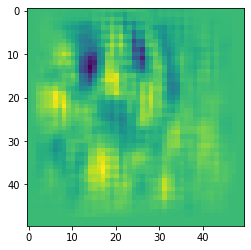

In [44]:
plt.imshow(act_grad)

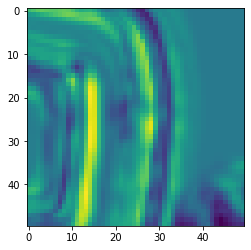

In [45]:
plt.imshow(salmap)

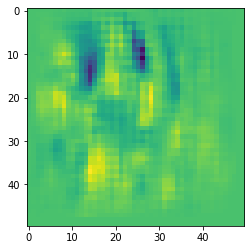

In [46]:
plt.imshow(salmap*act_grad)

In [14]:

def img_cam(act_grad, img, std):
    # Gradients zero to one
    act_grad = cv2.resize(act_grad, (img.shape[0],img.shape[1]))
    mask = np.where(act_grad, (abs(act_grad)>std*2), 0)
    mask = np.expand_dims(mask, -1)
    
    act_grad -= act_grad.min()
    act_grad = act_grad / act_grad.max()
    
    # Make a three-channel heatmap out of the one channel gradients
    heatmap = cv2.applyColorMap(np.uint8(255 * act_grad), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap * mask
    heatmap = heatmap * 255
    
    #img = img / 255
    
    cam = heatmap*.5 + img
    
    #cam = cam / cam.max()
    #cam = cam * 255
    cam = np.clip(cam, 0, 255)
    cam = cam.astype(np.uint8)
    
    return cam

In [15]:
std = np.array(act_grads[20:]).std()
img_cams = []
for img, act_grad in zip(imgs,act_grads):
    img_cams.append(img_cam(act_grad,img,std))

In [16]:
# IG vid

img1 = img_cams[0]
height , width , layers = img1.shape
fps = 20

video = cv2.VideoWriter('cams.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(imgs)-1):
    img = img_cams[i] # cv2 expects out of 255, integers
    img = np.flip(img, -1)
    video.write(img)
    
cv2.destroyAllWindows()
video.release()

In [9]:
# Just the vid

#img1 = img_cams[0]
img1 = imgs[0]
height , width , layers = img1.shape
fps = 20

video = cv2.VideoWriter('cams.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(imgs)-1):
    img = imgs[i]
    img = np.flip(img, -1)
    #img = img_cams[i] # cv2 expects out of 255, integers
    video.write(img)
    
cv2.destroyAllWindows()
video.release()

In [10]:
salmap.shape

(1, 16, 29, 29)